In [11]:
import cv2
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import psutil
from tqdm.auto import tqdm
import scipy
from PIL import Image, ImageDraw
from sklearn.preprocessing import OrdinalEncoder
from skimage.transform import hough_line
from matplotlib import cm
import pandas as pd
import pickle

In [19]:
def draw_image(lines, resolution="auto", padding=10, verbose=False):
    if type(lines) != np.ndarray:
        lines = np.array(lines)

    min_x, max_x = lines[:, ::2].min(), lines[:, ::2].max()
    min_y, max_y = lines[:, 1::2].min(), lines[:, 1::2].max()

    if verbose:
        print(min_x, max_x, min_y, max_y, '\r\n', resolution)

    image = Image.new("1", resolution, "black")
    draw = ImageDraw.Draw(image)

    scale_x = (resolution[0] - 2 * padding) / (max_x - min_x)
    scale_y = (resolution[1] - 2 * padding) / (max_y - min_y)

    scale = min(scale_x, scale_y)

    for line in lines:
        line = (
            int((line[0] - min_x) * scale + padding),
            int((line[1] - min_y) * scale + padding),
            int((line[2] - min_x) * scale + padding),
            int((line[3] - min_y) * scale + padding)
        )
        if verbose:
            print(line)
        draw.line(line, fill="white", width=1)

    return image



from matplotlib import cm

def print_accumulator(angle_step, h, theta, d, ax):
    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
              np.rad2deg(theta[-1] + angle_step),
              d[-1] + d_step, d[0] - d_step]
    
    ax.imshow(np.log(1 + h), 
              extent=bounds, 
              cmap=cm.gray, 
              aspect=1 /2
             )
    ax.set_title('Hough Accumulator H')
    ax.set_xlabel('Angles (degrees)')
    ax.set_ylabel('Distance (pixels)')
    return ax



from PIL import ImageOps

def plot_trj2img_steps(fft_imgs, geolet_key):
    lines, img, h, h_sum, fft = fft_imgs[geolet_key]

    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    
    axes[0].imshow(ImageOps.invert(img))
    axes[0].axis('off')
    axes[0].set_title('Trajectory')
    
    print_accumulator(angle_step, h, theta, d, axes[1])
    
    axes[2].plot(np.max(h_sum)-h_sum)
    axes[2].set_title("sum_col(H)")
    axes[2].set_ylim(0, 220)
    
    axes[3].plot(np.log2(fft))
    axes[3].set_title("FFT(sum_col(H))")
    axes[3].set_ylim(0, 17)

In [13]:
with open("../Data/Not_Resampled/FIXED_mean_not_resample_5km_euc/model.pkl", "rb") as fd:
    geolet = pickle.load(fd)

In [14]:
geolets = geolet.candidate_geolets
geolets_keys = np.array(list(geolets.keys()))
dist_matrix = geolet.selector.dist_matrix

In [15]:
imgs = dict()

for geolet_id, geolet_data in tqdm(geolets.items()):
    lines = [(x1, y1, x2, y2) for x1, x2, y1, y2 in zip(geolet_data.longitude[:-1], geolet_data.longitude[1:], 
                                                        geolet_data.latitude[:-1], geolet_data.latitude[1:])]
    img = draw_image(lines, (320, 320), verbose=False)
    imgs[geolet_id] = (lines, img)

  0%|          | 0/9880 [00:00<?, ?it/s]

/tmp/ipykernel_284155/961280895.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  scale_y = (resolution[1] - 2 * padding) / (max_y - min_y)
/tmp/ipykernel_284155/961280895.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  scale_y = (resolution[1] - 2 * padding) / (max_y - min_y)


In [16]:
from skimage.transform import hough_line
import scipy

angle_step = 1
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, int(180 / angle_step), endpoint=False)

fft_imgs = dict()

for geolet_id, (lines, img) in tqdm(imgs.items()):
    h, theta, d = hough_line(np.array(img), theta=tested_angles)
    h = np.log(1 + h)
    h_sum = h.sum(axis=0)
    fft = np.abs(scipy.fft.fft(h_sum))
    fft_imgs[geolet_id] = (lines, img, h, h_sum, fft)

  0%|          | 0/9880 [00:00<?, ?it/s]

In [24]:
dist_matrix_img_fft = np.vstack([fft for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(fft_imgs.items())])
dist_matrix_img_h = np.vstack([h.flatten() for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(fft_imgs.items())])
dist_matrix_img_h_sum = np.vstack([h_sum for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(fft_imgs.items())])

print(dist_matrix_img_fft.shape)
print(dist_matrix_img_h.shape)
print(dist_matrix_img_h_sum.shape)

  0%|          | 0/9880 [00:00<?, ?it/s]

  0%|          | 0/9880 [00:00<?, ?it/s]

  0%|          | 0/9880 [00:00<?, ?it/s]

(9880, 180)
(9880, 163260)
(9880, 180)


  0%|          | 0/11 [00:00<?, ?it/s]

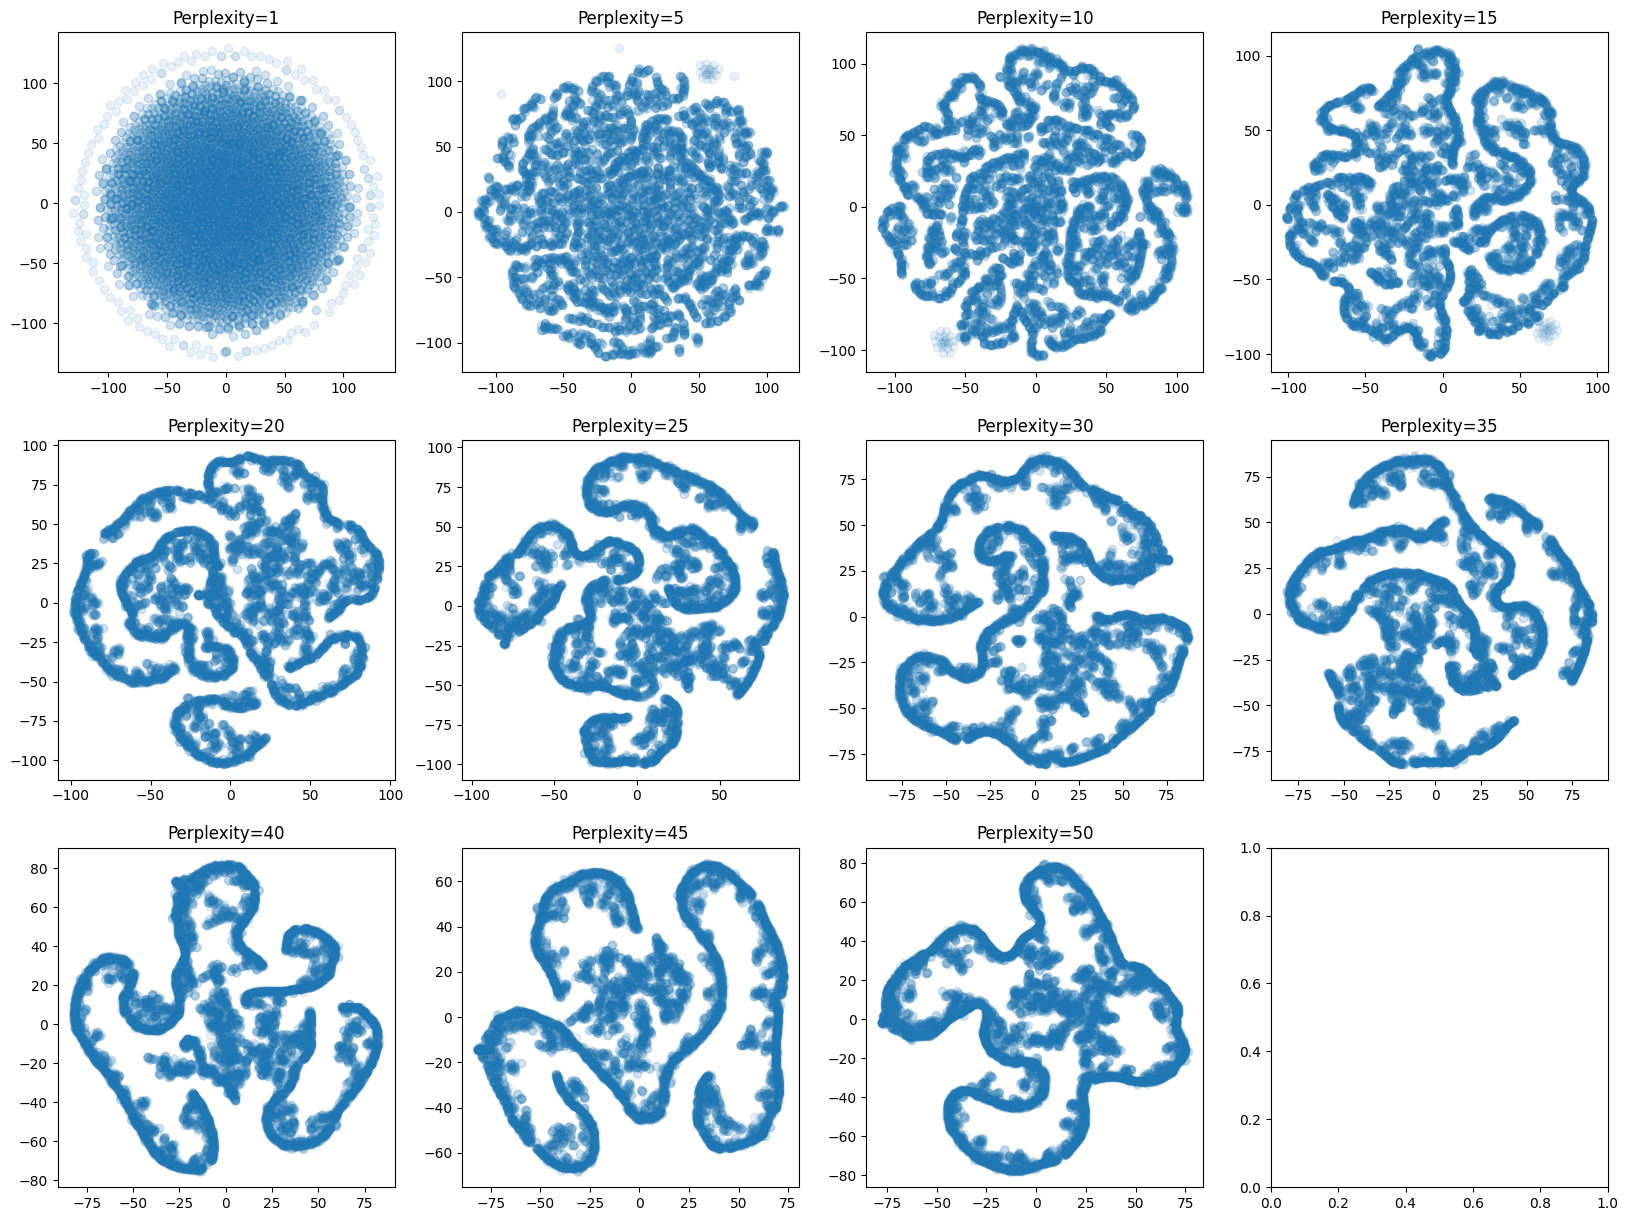

In [25]:
from sklearn.manifold import TSNE

_, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()

for ax, perplexity in zip(axs, tqdm(range(0, 50+1, 5))):
    tsne = TSNE(n_components=2, init="random", n_jobs=128, perplexity=max(1, perplexity))

    tsne_projection = tsne.fit_transform(dist_matrix_img_h_sum)
    
    ax.scatter(tsne_projection[:, 0], tsne_projection[:, 1], alpha=.1)
    ax.set_title(f'Perplexity={max(1, perplexity)}')

plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

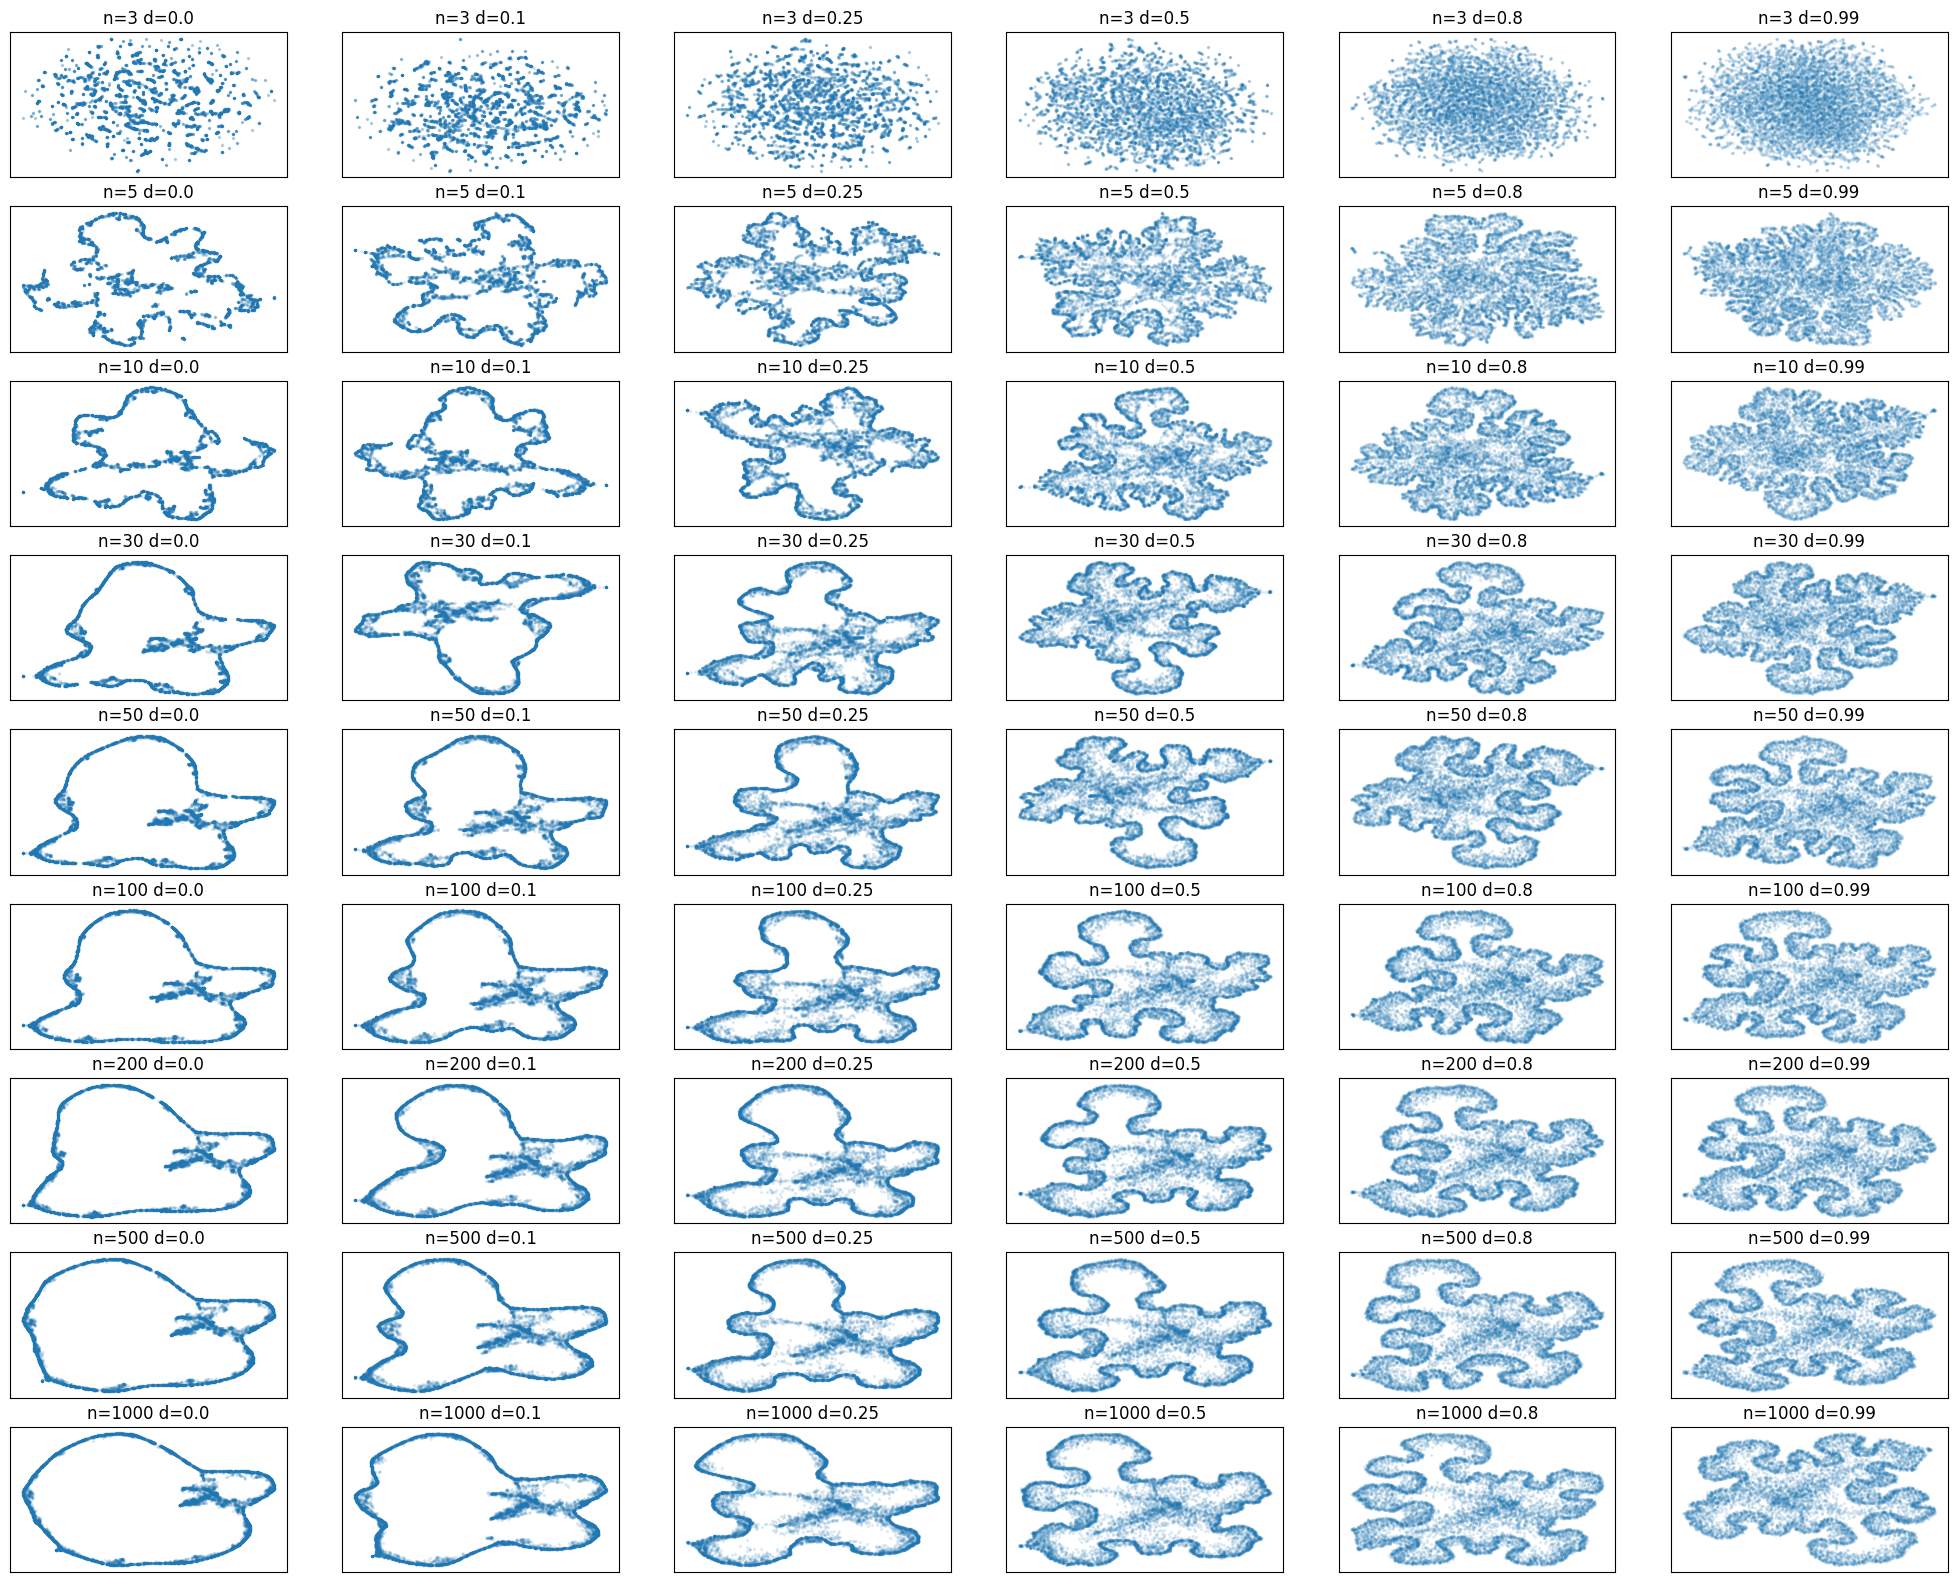

In [29]:
import umap
import warnings
warnings.filterwarnings("ignore")

n_neighbors_list = [3, 5, 10, 30, 50, 100, 200, 500, 1000]
min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

_, axs = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(25, 20))

for i, n_neighbors in enumerate(tqdm(n_neighbors_list)):
    for j, min_dist in enumerate(min_dist_list):
        reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist)
        embedding = reducer.fit_transform(dist_matrix_img_h_sum)
        axs[i, j].scatter(embedding[:, 0], embedding[:, 1], alpha=.1, s=2)
        axs[i, j].set_title(f'n={n_neighbors} d={min_dist}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.show()

In [33]:
from sklearn.cluster import OPTICS

op_res_img = OPTICS(n_jobs=128).fit_predict(dist_matrix_img_h_sum)

len(np.unique(op_res_img))

171

In [35]:
centroids = []

for idx in np.unique(op_res_img):
    df_features_sub = dist_matrix_img_h_sum[np.where(op_res_img==idx)]
    centroids.append(np.mean(df_features_sub, axis=0))

medoids = []
for centroid in centroids:
    df_features_sub = np.abs(np.copy(dist_matrix_img_h_sum) - centroid)
    medoids.append((np.argmin(df_features_sub.sum(axis=1)), df_features_sub[np.argmin(df_features_sub.sum(axis=1))]))

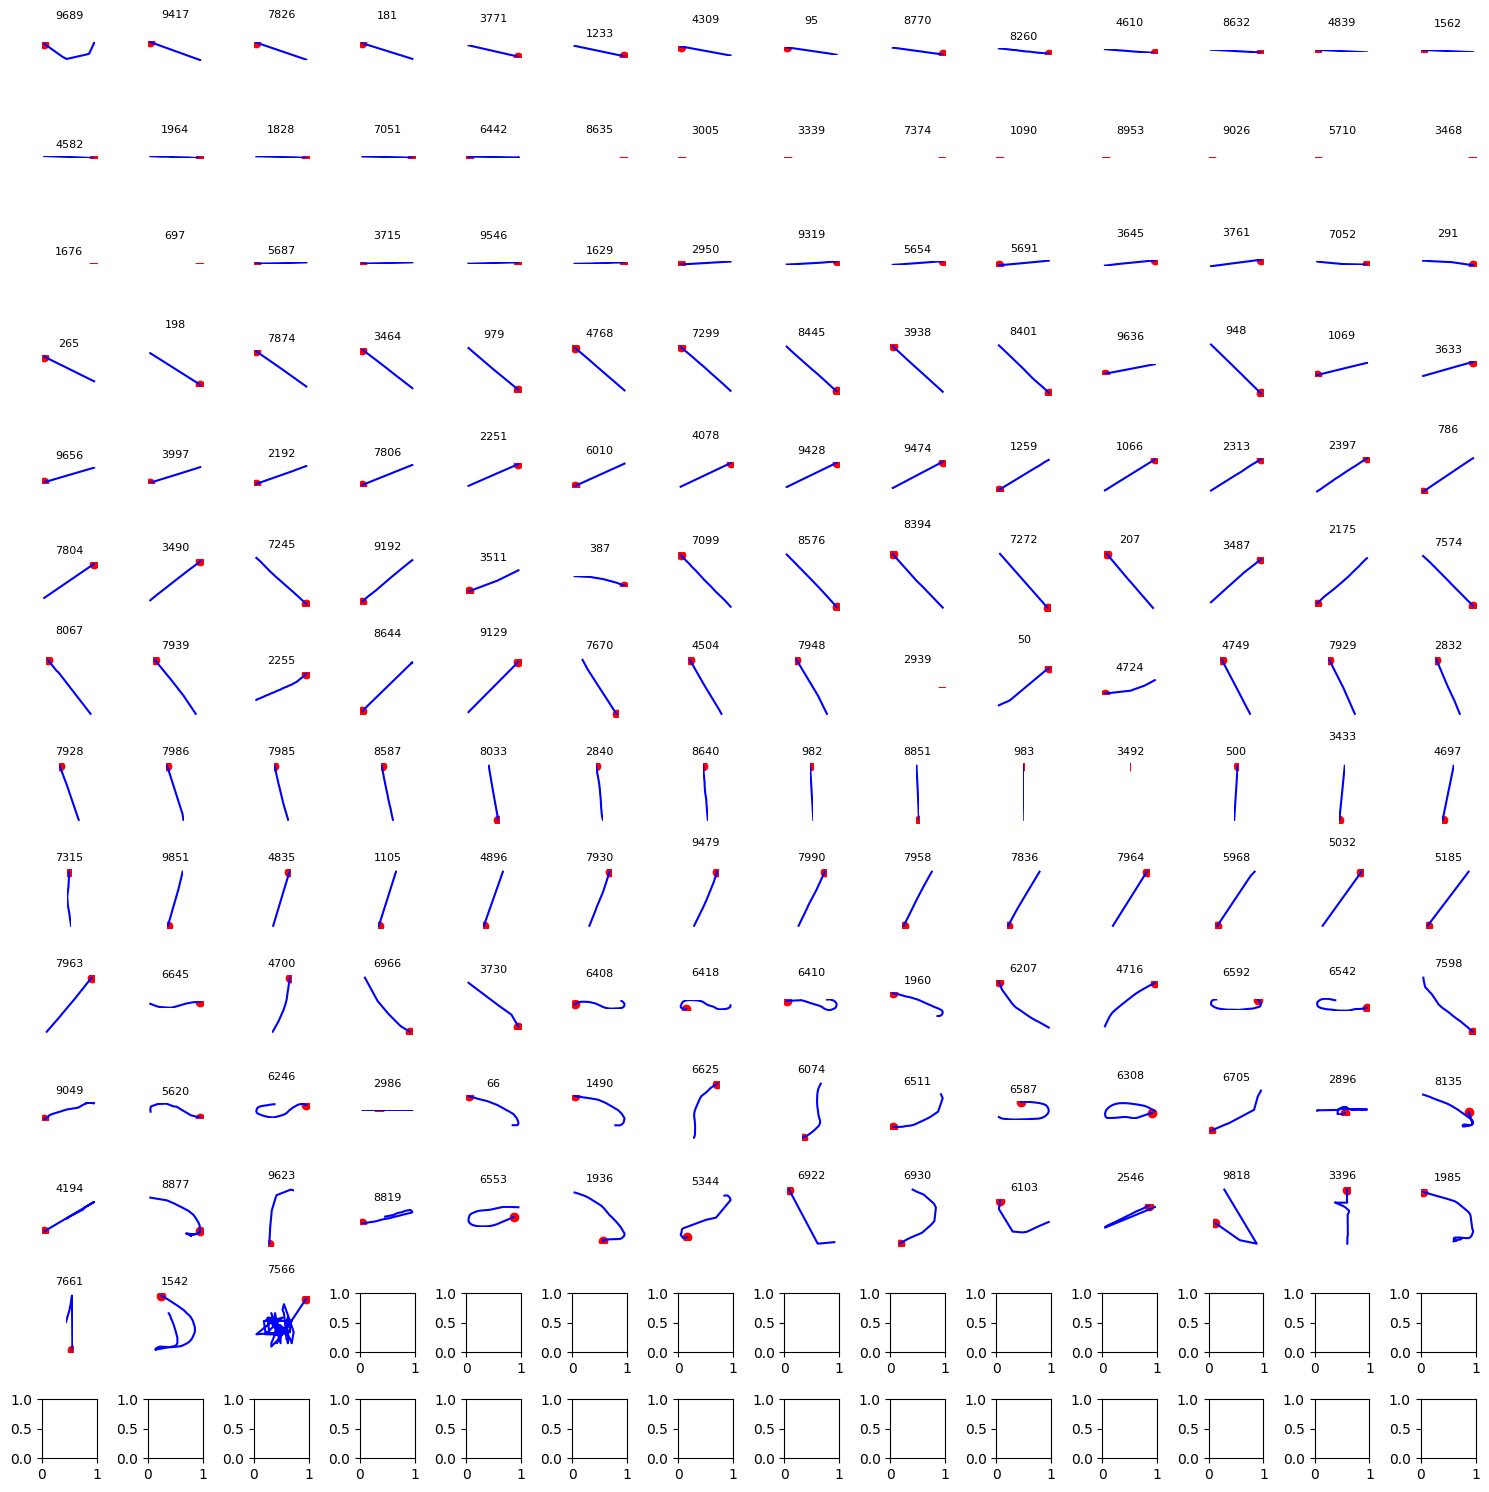

In [36]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id, _) in zip(axes, medoids):
    geolet_data = geolets[geolets_keys[geolet_id]]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id, fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()